# Análisis de cambios en la vegetación con NDVI



Este script presenta se presenta como un complemento a los análisis expuestos en el documento del Trabajo de fin de máster. El análisis se utiliza como indicio de deforestación mediante el índice de vegetación de diferencia normalizada (NDVI)

La idea de este script es mostrar otras posibilidades de análisis que permitan ser tenidos en cuenta en el desarrollo de las siguientes fases del proyecto piloto de la RHVA en el marco del Ordenamiento Territorial Alrededor del Agua, como la deforestación o la perdida de cobertura vegetal. Identifcar las áreas con presencia de estos fenomenos es clave para direccionar esfuerzos de intervención, conservación, restauración y protección, garantizando la seguridad hídrica del territorio

Cabe mencionar que este ejercicio no se incluye dentro del documento formal del TFM, puesto que los resultados presentan sesgo muy alto por cobertura de nubes. No obstante, el ejercicio de muestra que al dar el tratamiento adecuado del problema de cobertura de nubes, pueden obtenerse resultados a través de un procesamiento semiautomatizado de carga de imágenes desde GEE.

**Sección 1:** La primera sección de este notebook presenta el análisis realizado en la totalidad de la RHVA con imagenes MODIS del dataset MOD13Q1, el cual incorpora los cálculos de NDVI y EVI en sus bandas con una resolución de 250m

**Sección 2:** la segunda sección del notebook, explora el análisis en un área más pequeña correspondiente a la Región estudiada en la fase 1 del proyecto piloto, que cubre cinco municipios con imagenes con menor cobertura de nubes de los satélites Landsat 7 del ao 2002 y Sentinel 2 del año 2022, y mejor resolución 30m y 10m, respectivamente.

## Análisis de el NDVI en la RHVA con imágenes MODIS 250m

### Configuración del entorno

Instalación de librerías e importación de módulos

In [ ]:
!pip install geemap
!pip install imageio
!pip install geedim
!pip install rasterio

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 77.0 MB/s eta 0:00:00


In [ ]:
!pip install geemap --upgrade

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
import subprocess
from IPython.display import Image as IpyImage
from PIL import Image, ImageFont, ImageDraw, ImageSequence
import pandas as pd
import os
import imageio
import rasterio
from PIL import Image as PILImage
import numpy as np

import geopandas as gpd






In [ ]:
# Autenticación y inicialización de Google Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-rhva')

### Área de interés

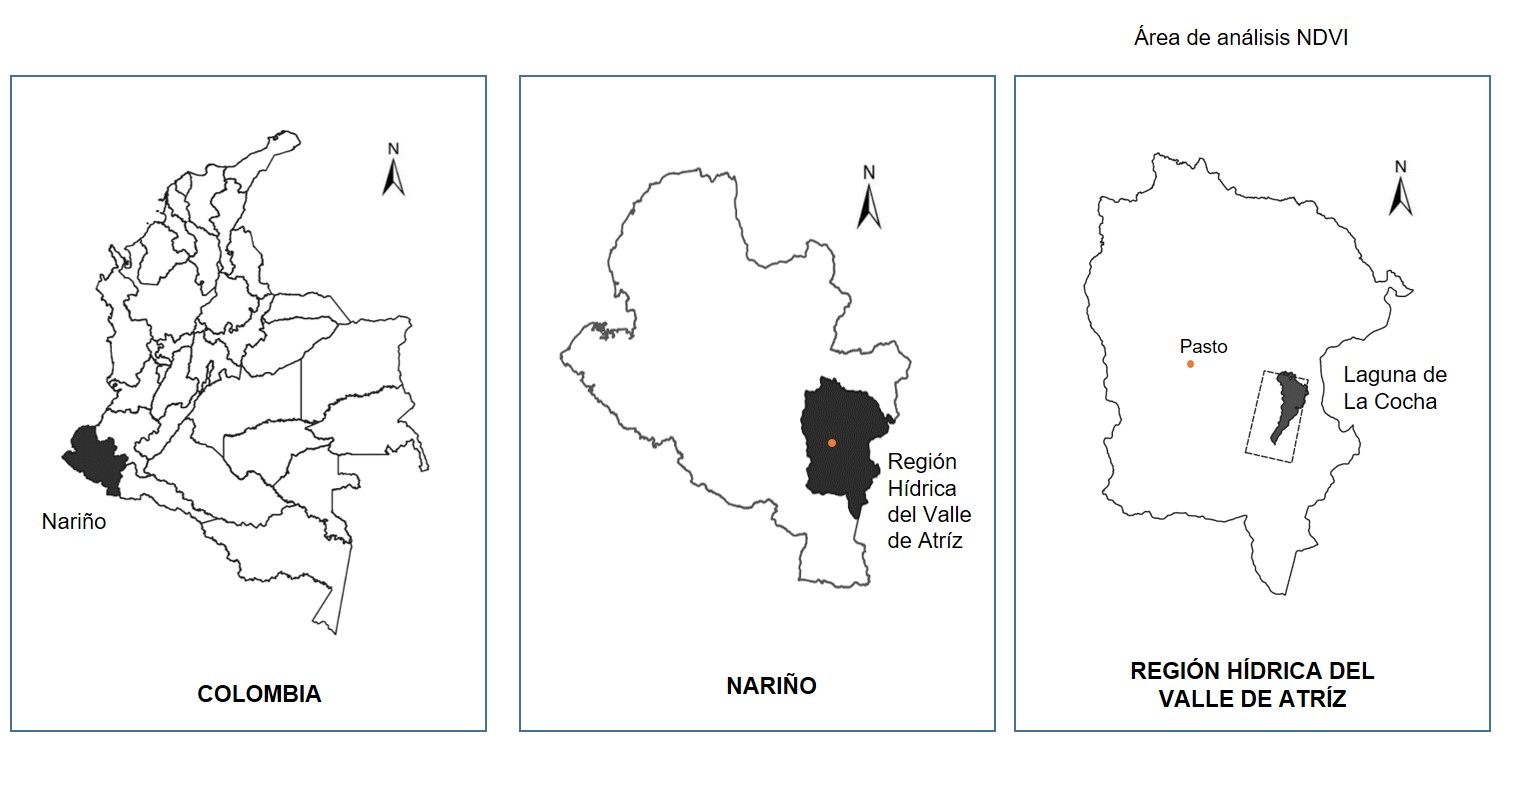

In [ ]:
# Definir geometria a partir de un shape

# Importa el archivo shapefile.
shapefile = ee.FeatureCollection('projects/ee-rhva/assets/RHVA')

# Define la geometría a partir del shapefile.
geometry = shapefile.geometry()

print(geometry)

# Obtener las coordenadas de la geometría
coordinates = geometry.coordinates().getInfo()

# Imprimir las coordenadas
print(coordinates)


ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.loadTable",
          "arguments": {
            "tableId": {
              "constantValue": "projects/ee-rhva/assets/RHVA"
            }
          }
        }
      }
    }
  }
})
[[[-77.51372256580711, 1.2934777103571182], [-77.5136019956539, 1.292754973287019], [-77.51353952311506, 1.2922701821184828], [-77.51336094246162, 1.2913095395973786], [-77.51324045942275, 1.2908247640746102], [-77.5131778116921, 1.2897429055419583], [-77.51317763669839, 1.2888990097697832], [-77.5129365826089, 1.287574822057001], [-77.51281601162447, 1.2868475991148984], [-77.51281592412732, 1.286452562878579], [-77.51269544051253, 1.2856670007793536], [-77.51251694603437, 1.2851283855925237], [-77.51227589054805, 1.284284467916453], [-77.51233372641174, 1.2830769091109155], [-77.51221315478982, 1.282354219

### Selección de imágenes MODIS - MOD13Q1


El producto MOD13Q1 V6.1 proporciona un valor de índice de vegetación (VI) por píxel. Hay dos capas de vegetación principales. La primera es el índice de vegetación de diferencia normalizada (NDVI), que se conoce como el índice de continuidad del NDVI existente derivado del radiómetro avanzado de muy alta resolución de la Administración Nacional Oceánica y Atmosférica (NOAA-AVHRR). La segunda capa de vegetación es el índice de vegetación mejorado (EVI), que minimiza las variaciones de fondo del dosel y mantiene la sensibilidad en condiciones de vegetación densa. El EVI también utiliza la banda azul para eliminar la contaminación atmosférica residual causada por el humo y las nubes delgadas de subpíxeles. Los productos MODIS NDVI y EVI se calculan a partir de reflectancias de superficie bidireccionales corregidas atmosféricamente que se han enmascarado para el agua, las nubes, los aerosoles pesados ​​y las sombras de las nubes.


Resolución: 250 m

Bandas: NDVI y EVI

Fuente: [Dataset MOD13Q1 GEE](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1#description)



In [ ]:
# Filtrar las imágenes MODIS por fecha y cobertura de nubes
image_collection = ee.ImageCollection("MODIS/061/MOD13Q1")\
    .filterBounds(geometry)\
    .filterDate('2000-01-01', '2024-12-31')\

# Imprimir la cantidad de imagenes encontradas
print(image_collection.size().getInfo())

563


In [ ]:

# Obtener la cantidad de imágenes en la colección
num_images = image_collection.size().getInfo()

# Crear un DataFrame de pandas con el número de imágenes
data = {'Número de imágenes': [num_images]}
df = pd.DataFrame(data)

# Guardar el DataFrame en un archivo CSV
df.to_csv('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA/numero_imagenes.csv', index=False)




### Serie temporal del NDVI de 2000 a 2024

Se selecciona una imagen por año, aquellas con el NDVI más bajo para el área de estudio

In [ ]:
# Añadir una propiedad 'year' a cada imagen
def addYear(image):
    year = ee.Date(image.get('system:time_start')).get('year')
    return image.set('year', year)

image_collection = image_collection.map(addYear)

# Calcular el NDVI promedio de cada imagen dentro del área de estudio
def calculate_mean_ndvi(image):
    mean_ndvi = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=250,  # Escala en metros (MODIS tiene una resolución de 250m para NDVI)
        maxPixels=1e9
    ).get('NDVI')
    return image.set('mean_ndvi', mean_ndvi)

# Añadir el NDVI promedio como una propiedad a cada imagen
image_collection = image_collection.map(calculate_mean_ndvi)

# Función para obtener la imagen con el NDVI promedio más bajo por año
def get_min_ndvi_image(year):
    year_collection = image_collection.filter(ee.Filter.eq('year', year))
    min_ndvi_image = year_collection.sort('mean_ndvi').first()
    return min_ndvi_image.set('year', year)

# Generar una lista de años de interés
years = ee.List.sequence(2000, 2024)

# Aplicar la función para cada año y convertirla a una lista de imágenes
min_ndvi_images = years.map(get_min_ndvi_image)

# Convertir a una ImageCollection
min_ndvi_image_collection = ee.ImageCollection(min_ndvi_images)

# Ahora puedes realizar análisis adicionales con esta colección, por ejemplo, obtener la serie temporal de NDVI promedio
def annual_mean_ndvi(image):
    year = image.get('year')
    mean_ndvi = image.get('mean_ndvi')
    return ee.Feature(None, {'year': year, 'mean_ndvi': mean_ndvi})

# Aplicar la función para cada imagen en la colección
mean_ndvi_per_year = min_ndvi_image_collection.map(annual_mean_ndvi)

# Convertir los resultados en un formato legible
mean_ndvi_dict = mean_ndvi_per_year.getInfo()

# Extraer los datos y convertirlos a un DataFrame
years = []
mean_ndvi_values = []

for feature in mean_ndvi_dict['features']:
    properties = feature['properties']
    years.append(properties['year'])
    mean_ndvi_values.append(properties['mean_ndvi'])

# Crear un DataFrame con los resultados
import pandas as pd
df = pd.DataFrame({
    'Year': years,
    'Mean_NDVI': mean_ndvi_values
})

# Mostrar el DataFrame
print(df)

# Guardar en CSV
df.to_csv('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA/min_mean_ndvi_series.csv', index=False)

    Year    Mean_NDVI
0   2000  1942.683079
1   2001  3387.112016
2   2002  2746.909245
3   2003  3373.479326
4   2004  2882.584236
5   2005  2991.122680
6   2006  2898.818444
7   2007  3673.211162
8   2008  3624.469984
9   2009  3487.210424
10  2010  3628.857090
11  2011  3452.903574
12  2012  3589.690797
13  2013  2401.055274
14  2014  2078.167761
15  2015  2991.377151
16  2016   552.911132
17  2017  4123.899176
18  2018  3517.878198
19  2019  3125.105840
20  2020  3833.154474
21  2021  3216.749878
22  2022  4013.982246
23  2023  3414.967871
24  2024  4791.461735


### Visualización de serie temporal del NDVI desde 2000 al 2024

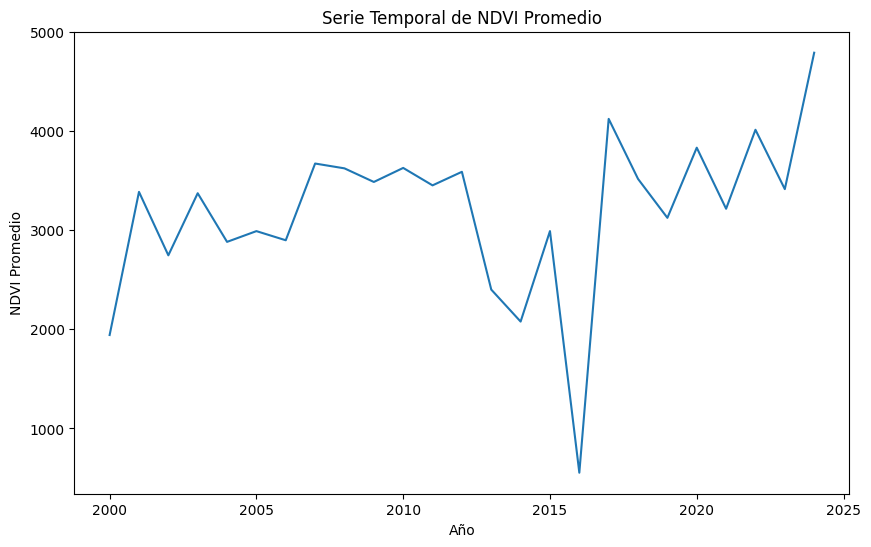

In [ ]:

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Mean_NDVI'])

# Agregar etiquetas y título
plt.xlabel('Año')
plt.ylabel('NDVI Promedio')
plt.title('Serie Temporal de NDVI Promedio')

plt.savefig('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA/min_mean_ndvi_series.png')

# Mostrar el gráfico
plt.show()




### Animación GIF para visualizar cambios

In [ ]:
# Lista de años de interés
years = list(range(2000, 2025))

for year in years:
    min_ndvi_image = get_min_ndvi_image(ee.Number(year))

    task = ee.batch.Export.image.toDrive(**{
        'image': min_ndvi_image.visualize(**{
            'bands': ['NDVI'],
            'min': 0,
            'max': 8000,  # Ajusta el rango de NDVI según tus datos específicos
            'palette': ['white', 'green']
        }),
        'description': f'NDVI_{year}',
        'folder': 'GEE_Exports',  # Llevar imagenes manualmente a carpeta deseada
        'fileNamePrefix': f'NDVI_{year}',
        'scale': 250,  # Resolución de MODIS
        'region': geometry,
        'maxPixels': 1e9
    })

    task.start()
    print(f"Export task started for year {year}")

Export task started for year 2000
Export task started for year 2001
Export task started for year 2002
Export task started for year 2003
Export task started for year 2004
Export task started for year 2005
Export task started for year 2006
Export task started for year 2007
Export task started for year 2008
Export task started for year 2009
Export task started for year 2010
Export task started for year 2011
Export task started for year 2012
Export task started for year 2013
Export task started for year 2014
Export task started for year 2015
Export task started for year 2016
Export task started for year 2017
Export task started for year 2018
Export task started for year 2019
Export task started for year 2020
Export task started for year 2021
Export task started for year 2022
Export task started for year 2023
Export task started for year 2024


In [ ]:
# Convertir imagenes a jpg para la animacion GIF

import os
from PIL import Image

# Ruta a la carpeta que contiene las imágenes TIFF
input_folder = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA/Images TIFF'  # Reemplaza con la ruta correcta

# Ruta a la carpeta donde se guardarán las imágenes JPG
output_folder = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA/Images JPG'  # Reemplaza con la ruta correcta

# Crea la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Recorre todos los archivos en la carpeta de entrada
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        # Construye la ruta completa al archivo de entrada
        input_path = os.path.join(input_folder, filename)

        # Abre la imagen TIFF
        img = Image.open(input_path)

        # Construye la ruta completa al archivo de salida
        output_path = os.path.join(output_folder, filename.replace(".tif", ".jpg"))

        # Guarda la imagen como JPG
        img.save(output_path, "JPEG")

print("Imágenes convertidas a JPG correctamente.")


Imágenes convertidas a JPG correctamente.


In [ ]:
# prompt: crear gif con label del año con las imagenes descargadas jpg

# Ruta a la carpeta que contiene las imágenes JPG
image_folder = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA/Images JPG'  # Reemplaza con la ruta correcta

# Ruta al archivo GIF de salida
output_gif = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA/ndvi_animation_RHVA.gif'  # Reemplaza con la ruta correcta

# Obtener la lista de imágenes JPG
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
image_files.sort()  # Asegúrate de que las imágenes estén ordenadas por nombre

# Crear una lista para almacenar las imágenes
images = []

# Cargar las imágenes y agregar el texto del año
for filename in image_files:
  image_path = os.path.join(image_folder, filename)
  img = Image.open(image_path)

  # Obtener el año del nombre de archivo
  year = filename.split('_')[1].split('.')[0]

  # Agregar texto al año
  draw = ImageDraw.Draw(img)
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 30)  # Puedes cambiar la fuente y el tamaño
  draw.text((10, 10), f"Año: {year}", font=font, fill=(255, 255, 255))  # Ajusta la posición y el color del texto

  images.append(img)

# Guardar la animación GIF
imageio.mimsave(output_gif, images, fps=1)

print(f"GIF creado en: {output_gif}")


GIF creado en: /content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/ndvi_animation_RHVA.gif


### Variaciones del NDVI

#### Estimación de área deforestada

Se asumen que cambios en el NDVI corresponden a indicios de deforestación o perdida de cobertura vegetal

In [ ]:
# Calcular cambios para ver si se ha perdido o no vegetacion

# Obtener las imágenes para 2002 y 2024
image_2002 = min_ndvi_image_collection.filter(ee.Filter.eq('year', 2002)).first()
image_2024 = min_ndvi_image_collection.filter(ee.Filter.eq('year', 2024)).first()

# Calcular la diferencia de NDVI
diff_ndvi = image_2024.select('NDVI').subtract(image_2002.select('NDVI'))

# Crear una máscara para áreas con cambio significativo de NDVI
deforestation_mask = diff_ndvi.lt(0)  #  Se ha perdido vegetación si la diferencia es menor que 0

# Calcular el área de deforestación
deforestation_area = deforestation_mask.multiply(ee.Image.pixelArea()).reduceRegion(
    reducer= ee.Reducer.sum(),
    geometry= geometry,
    scale= 250,
    maxPixels=1e13
)

# Obtener el área de deforestación en hectáreas
deforestation_area_ha = ee.Number(deforestation_area.get('NDVI')).divide(10000)

# Imprimir el área de deforestación
print('Área de deforestación:', deforestation_area_ha.getInfo(), 'ha')


Área de deforestación: 62629.439005984976 ha


In [ ]:
# Exportar la imagen de diferencia de NDVI como TIFF
task = ee.batch.Export.image.toDrive(**{
    'image': diff_ndvi,
    'description': 'diff_ndvi_RHVA',
    'folder': 'GEE_Exports',  # Llevar imagenes manualmente a carpeta deseada
    'fileNamePrefix': 'diff_ndvi_RHVA',
    'scale': 250,  # Resolución de MODIS
    'region': geometry,
    'maxPixels': 1e9
})

task.start()
print("Export task started for diff_ndvi_RHVA")


Export task started for diff_ndvi_RHVA


In [ ]:

# Convertir el resultado a un diccionario
deforestation_area_dict = {'Área de deforestación (ha)': [deforestation_area_ha.getInfo()]}

# Crear un DataFrame de pandas
df_deforestation = pd.DataFrame(deforestation_area_dict)

# Guardar el DataFrame en un archivo CSV
df_deforestation.to_csv('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA/deforestation_area.csv', index=False)


#### Visualización interactiva RHVA, RHVA_fase1 y Laguna de LAa Cocha

Evidenciar resultados en el área de intervención de la fase 1 y el área de la Laguna de La Cocha

In [ ]:
# Visulizar resultado en mapa

# Inicializar el mapa
Map = geemap.Map()

# Importa el archivo shapefile desde GEE
ai_fase1 = ee.FeatureCollection('projects/ee-rhva/assets/area_intervencion')
la_cocha= ee.FeatureCollection('projects/ee-rhva/assets/geometry_gee_LaCocha')

# Añadir las geometrías de los nuevos layers como capas
Map.addLayer(ai_fase1, {}, 'Área de intervención Fase1')
Map.addLayer(la_cocha, {}, 'Laguna de La Cocha')

# Añadir la geometría del shapefile como una capa
Map.addLayer(shapefile, {}, 'RHVA')

# Visualizar la diferencia de NDVI
vis_params = {
    'min': -2000,
    'max': 2000,
    'palette': ['blue', 'white', 'red']
}
Map.addLayer(diff_ndvi, vis_params, 'Diferencia de NDVI (2024 - 2002)')

# Visualizar la máscara de deforestación
Map.addLayer(deforestation_mask, {'palette': ['green', 'red']}, 'Máscara de Deforestación')

# Centrar el mapa en la geometría
Map.centerObject(shapefile, 10)

# Mostrar el mapa
Map


Map(center=[1.1718846603852011, -77.26166242829005], controls=(WidgetControl(options=['position', 'transparent…

#### Visualización de deforestación entre 2002 y 2024

Se asume que un cambio negativo en NDVI es indicio de deforestación

In [ ]:
# Descargar mascara de deforestacion

# Exportar la máscara de deforestación a Google Drive
task = ee.batch.Export.image.toDrive(**{
    'image': deforestation_mask,
    'description': 'deforestation_mask',
    'folder': 'GEE_Exports', # Llevar manualmente a carpeta deseada
    'fileNamePrefix': 'deforestation_mask',
    'scale': 250,
    'region': geometry,
    'maxPixels': 1e13
})

task.start()
print("Tarea de exportación iniciada.")


Tarea de exportación iniciada.


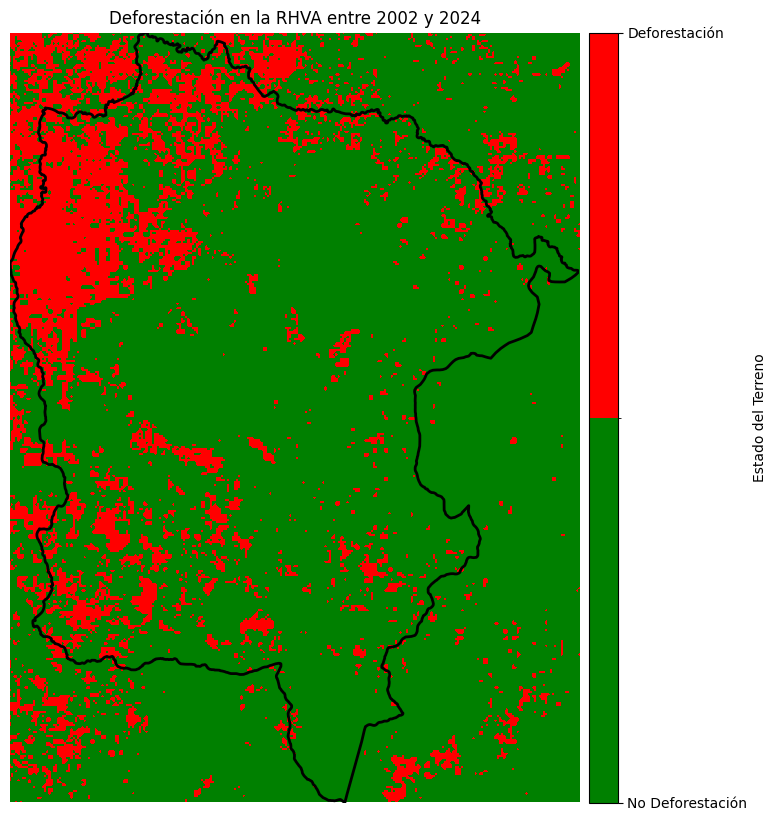

In [ ]:
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Cargar la máscara de deforestación
mask_deforestation_path = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA/deforestation_mask.tif'  # Reemplaza con la ruta a tu máscara de deforestación

with rasterio.open(mask_deforestation_path) as src_mask:
    mask_deforestation = src_mask.read(1)
    extent = src_mask.bounds

# Cargar el shapefile reproyectado de la RHVA
rhva_shape_reprojected = gpd.read_file('/content/drive/MyDrive/TFM/Repositorio/0-AOI/RHVA/RHVA_CRS_Reproyectado.shp')

# Crear una figura para la visualización combinada
fig, ax = plt.subplots(figsize=(10, 10))

# Crear un mapa de colores para la deforestación (rojo) y no deforestación (verde)
cmap = plt.cm.colors.ListedColormap(['green', 'red'])
bounds = [0, 0.5, 1]  # Definir los límites de los valores
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# Mostrar la máscara de deforestación
im = ax.imshow(mask_deforestation, cmap=cmap, norm=norm, extent=[extent.left, extent.right, extent.bottom, extent.top])

# Superponer el contorno de la RHVA
rhva_shape_reprojected.boundary.plot(ax=ax, color='black', linewidth=2)

# Añadir una barra de color con una leyenda
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Deforestación', 'Deforestación'])
cbar.set_label('Estado del Terreno')

# Ajustar los límites del gráfico según el shapefile reproyectado
ax.set_xlim(rhva_shape_reprojected.total_bounds[[0, 2]])
ax.set_ylim(rhva_shape_reprojected.total_bounds[[1, 3]])

# Añadir título y etiquetas
ax.set_title('Deforestación en la RHVA entre 2002 y 2024')
ax.set_axis_off()  # Ocultar los ejes para una mejor presentación

# Guardar y mostrar la imagen
plt.savefig('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA/deforestation_mask_map.png', dpi=300, bbox_inches='tight')
plt.show()


#### Visualización de cambios de NDVI entre 2002 y 2024

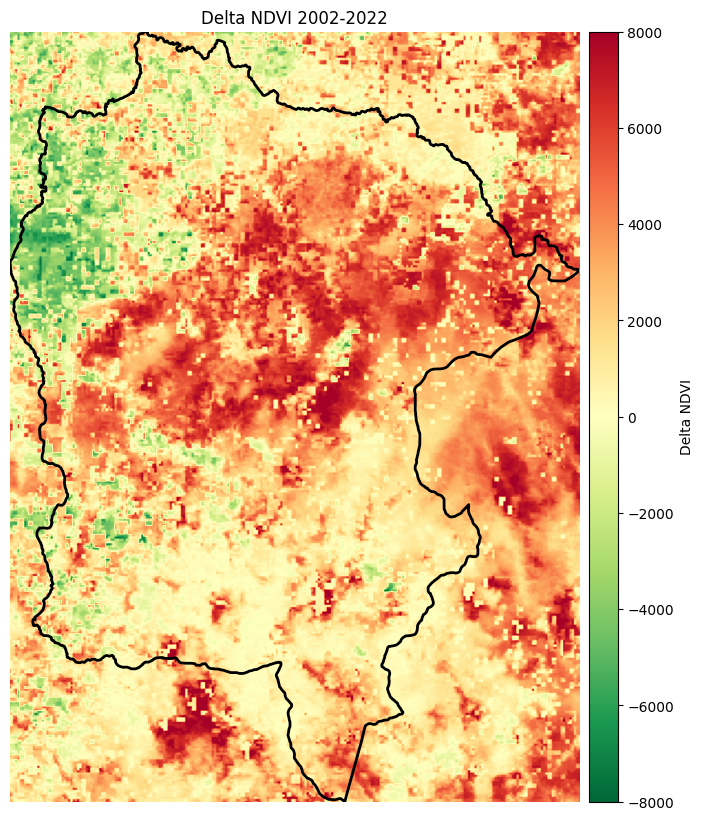

In [ ]:
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Ruta al archivo TIFF de diferencia de NDVI
diff_ndvi_path = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA/diff_ndvi_RHVA.tif'  # Reemplaza con la ruta a tu archivo TIFF de diferencia de NDVI

# Cargar el TIFF de diferencia de NDVI
with rasterio.open(diff_ndvi_path) as src:
    diff_ndvi = src.read(1)
    extent = src.bounds

# Cargar el shapefile reproyectado de la RHVA
rhva_shape_reprojected = gpd.read_file('/content/drive/MyDrive/TFM/Repositorio/0-AOI/RHVA/RHVA_CRS_Reproyectado.shp')

# Crear una figura para la visualización combinada
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar la imagen base de diferencia de NDVI
cmap = plt.get_cmap('RdYlGn_r')
im = ax.imshow(diff_ndvi, cmap=cmap, vmin=-8000, vmax=8000, extent=[extent.left, extent.right, extent.bottom, extent.top])

# Superponer el contorno de la RHVA
rhva_shape_reprojected.boundary.plot(ax=ax, color='black', linewidth=2)

# Ajustar los límites del gráfico según el shapefile reproyectado
ax.set_xlim(rhva_shape_reprojected.total_bounds[[0, 2]])
ax.set_ylim(rhva_shape_reprojected.total_bounds[[1, 3]])

# Añadir una barra de color con una leyenda
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Delta NDVI')

# Añadir título y etiquetas
ax.set_title('Delta NDVI 2002-2022')
ax.set_axis_off()  # Ocultar los ejes para una mejor presentación

# Guardar y mostrar la imagen
plt.savefig('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA/ndvi_delta_within_rhva.png', dpi=300, bbox_inches='tight')
plt.show()


## Análisis de NDVI en RHVA_Fase1 con imágenes Landsat y Sentinel

En la siguiente sección, se realiza el análisis de los cambios en el NDVI entre 2002 y 2024.

| Caracteristícas  | Landsat 7 2002   | Sentinel 2 |
|-------------|-------------|-------------|
| Dato 1      | Dato 2      | Dato 3      |
| Dato 4      | Dato 5      | Dato 6      |
| Dato 7      | Dato 8      | Dato 9      |

### Carga y visualización de imágenes

In [ ]:
path_to_image2002 = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA_fase1/landsat7_2002_visualización.tif'
path_to_image2022 = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA_fase1/Sentinel2_Mosaic_2022_Normalized.tif'

In [ ]:
# Abrir las imágenes
with rasterio.open(path_to_image2002) as src1:
    image1 = src1.read([3, 2, 1])  # Leer bandas RGB para verdadero color
    transform1 = src1.transform

with rasterio.open(path_to_image2022) as src2:
    image2 = src2.read([4, 3, 2])  # Leer bandas RGB para verdadero color
    transform2 = src2.transform

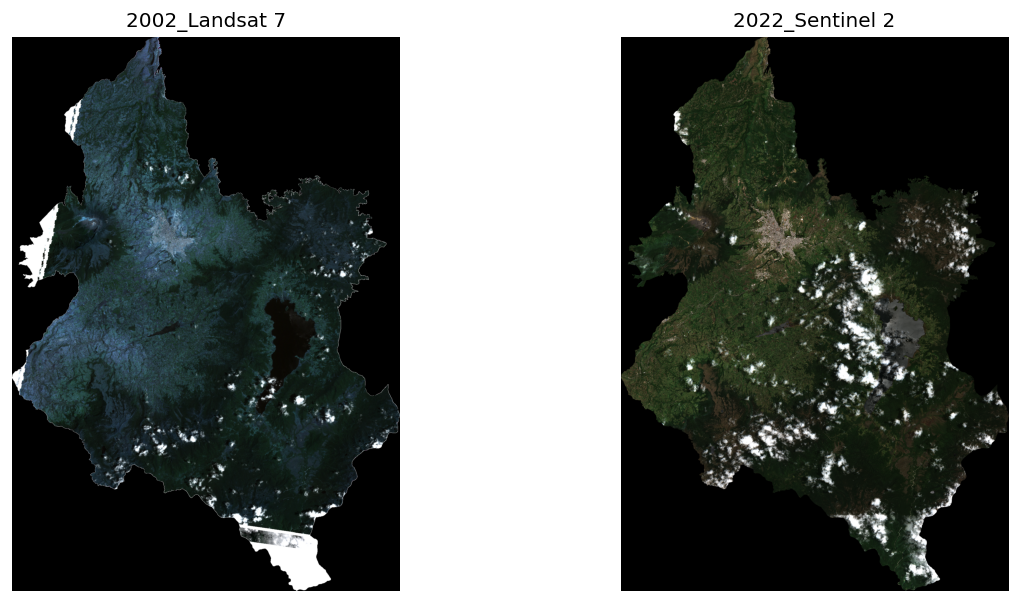

In [ ]:
# Configurar las subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=120)

# Mostrar la primera imagen
ax1.imshow(image1.transpose((1, 2, 0)))
ax1.set_title('2002_Landsat 7')
ax1.axis('off')  # Ocultar los ejes

# Mostrar la segunda imagen
ax2.imshow(image2.transpose((1, 2, 0)))
ax2.set_title('2022_Sentinel 2')
ax2.axis('off')  # Ocultar los ejes

plt.savefig('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA_fase1/landsat_sentinel_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

### Cálculo de NVDI con enmascaramiento de nubes desde GEE

Se probaron los métodos de enmascaramiento Q60, SLC con Python y enmascaramiento desde GEE, y los mejores resultados corresponden a GEE

Revisar [notebook_borrador](https://colab.research.google.com/drive/1aOlTpZOr-LUgMO608SHWE-Ncj659lFcT?usp=sharing)

In [ ]:
path_to_tiff2002 = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA_fase1/landsat7_2002.tif'
path_to_tiff2022_mask = '/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Data/RHVA_fase1/Sentinel2_Mosaic_2022_reprojected_mask.tif'

In [ ]:
# Abrir raw

with rasterio.open(path_to_tiff2002) as src:
    bandNIR2002 = src.read(4)  # Suponiendo que la banda NIR es la banda 8
    bandRed2002 = src.read(3)  # Suponiendo que la banda roja es la banda 4

with rasterio.open(path_to_tiff2022_mask) as src:
    bandNIR2022_mask = src.read(8)
    bandRed2022_mask = src.read(4)
    bandGreen2022_mask = src.read(3) # para calcular NDWI y enmascarar cuerpo de agua

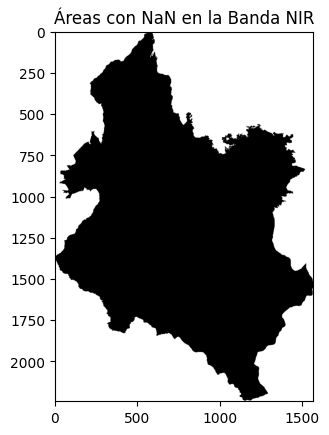

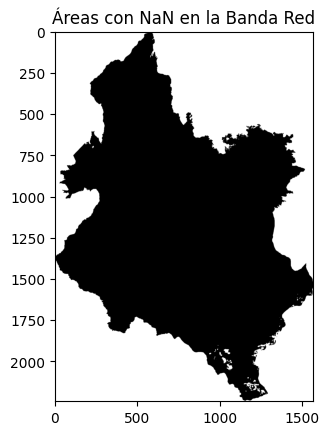

In [ ]:
# Identificar NaN en las bandas NIR y Red
nir_nan = np.isnan(bandNIR2022)
red_nan = np.isnan(bandRed2022_mask)

# Visualizar las áreas con NaN en la banda NIR
plt.imshow(nir_nan, cmap='gray')
plt.title('Áreas con NaN en la Banda NIR')
plt.show()

# Visualizar las áreas con NaN en la banda Red
plt.imshow(red_nan, cmap='gray')
plt.title('Áreas con NaN en la Banda Red')
plt.show()

### Cálculo de delta NDVI

In [ ]:
ndvi2002 = (bandNIR2002 - bandRed2002) / (bandNIR2002 + bandRed2002)
ndvi2022_mask = (bandNIR2022_mask - bandRed2022_mask) / (bandNIR2022_mask + bandRed2022_mask)

# Calcular NDWI usando las bandas Green y NIR
ndwi = (bandGreen2022_mask - bandNIR2022_mask) / (bandGreen2022_mask + bandNIR2022_mask)

# Definir un umbral para identificar el agua
water_mask2 = ndwi > 0.05  # Ajusta el umbral según sea necesario

# Enmascarar los cuerpos de agua en NDVI
ndvi2022_corrected2 = np.where(water_mask2, np.nan, ndvi2022_mask)

delta_ndvi_mask = ndvi2022_corrected2 - ndvi2002

In [ ]:
# Descargar resultado de delta ndvi en csv

import pandas as pd

# Convertir el array de delta_ndvi a un DataFrame de pandas
df_delta_ndvi = pd.DataFrame(delta_ndvi_mask)

# Guardar el DataFrame en un archivo CSV
df_delta_ndvi.to_csv('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA_fase1/delta_ndvi_mask.csv', index=False)


### Visualización antes y después, y delta NDVI

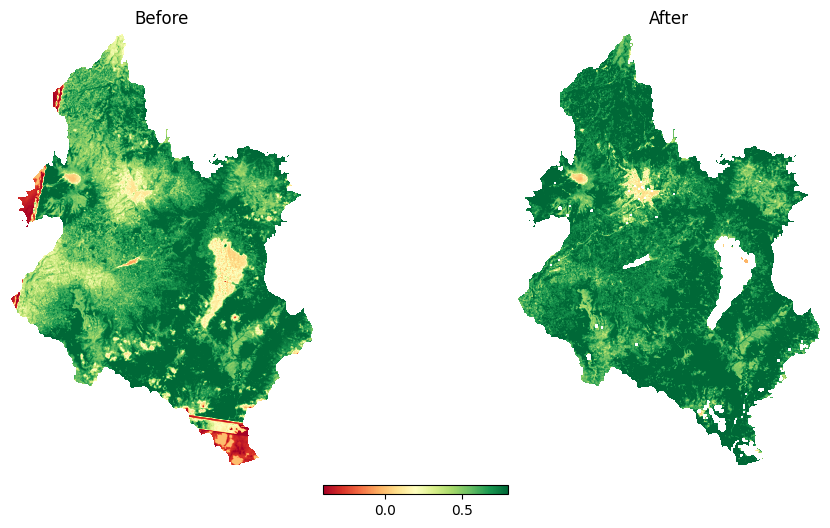

In [ ]:

# Crear una figura y dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Visualización del NDVI antes de la deforestación

im1 = ax1.imshow(ndvi2002, cmap='RdYlGn', vmin=-0.4, vmax=0.8)
ax1.title.set_text('Before')
ax1.axis('off')

# Visualización del NDVI después de la deforestación
im2 = ax2.imshow(ndvi2022_corrected2, cmap='RdYlGn', vmin=-0.4, vmax=0.8)
ax2.title.set_text('After')
ax2.axis('off')

# Añadir una barra de colores
fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', fraction=0.02, pad=0.04)

# Descargar plot
plt.savefig('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA_fase1/ndvi_before_after.png', dpi=300, bbox_inches='tight')
# Mostrar el gráfico
plt.show()

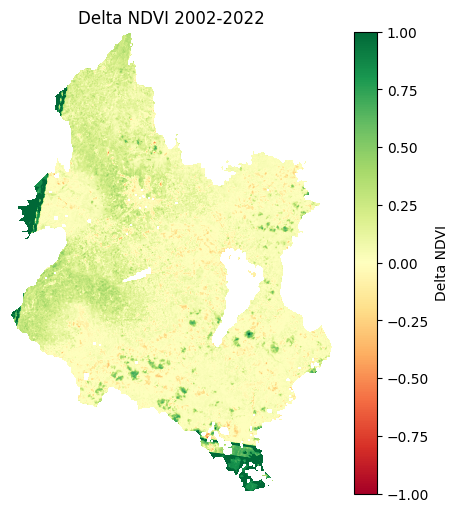

In [ ]:
# Visualizar delta

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Delta NDVI 2002-2022')
plt.imshow(delta_ndvi_mask, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='Delta NDVI')
plt.axis('off')

plt.savefig('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA_fase1/delta_ndvi_mask.png', dpi=300, bbox_inches='tight')
plt.show()

### Cálculo del delta NDVI asignando umbral de cambio

In [ ]:
deforestation_threshold = -0.1  # Definir un umbral para considerar deforestación

deforestation_mask = delta_ndvi_mask < deforestation_threshold

deforested_pixels = np.count_nonzero(deforestation_mask)

pixel_area_m2 = 100  # Si la resolución es 10m x 10m

deforested_surface = deforested_pixels * (pixel_area_m2 / 10000)  # Convertir a hectáreas

date_before = "2002"  # La fecha de la imagen de 2002
date_after = "2022"   # La fecha de la imagen de 2022

print(f"En este caso {deforested_surface} han sido deforestadas entre {date_before} y {date_after}")


En este caso 1136.5 han sido deforestadas entre 2002 y 2022


In [ ]:
# Descargar area total deforestada en csv


# Convertir el resultado a un diccionario
deforestation_area_dict = {'Área deforestada (ha)': [deforested_surface]}

# Crear un DataFrame de pandas
df_deforestation = pd.DataFrame(deforestation_area_dict)

# Guardar el DataFrame en un archivo CSV
df_deforestation.to_csv('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA_fase1/deforestation_area_fase1.csv', index=False)


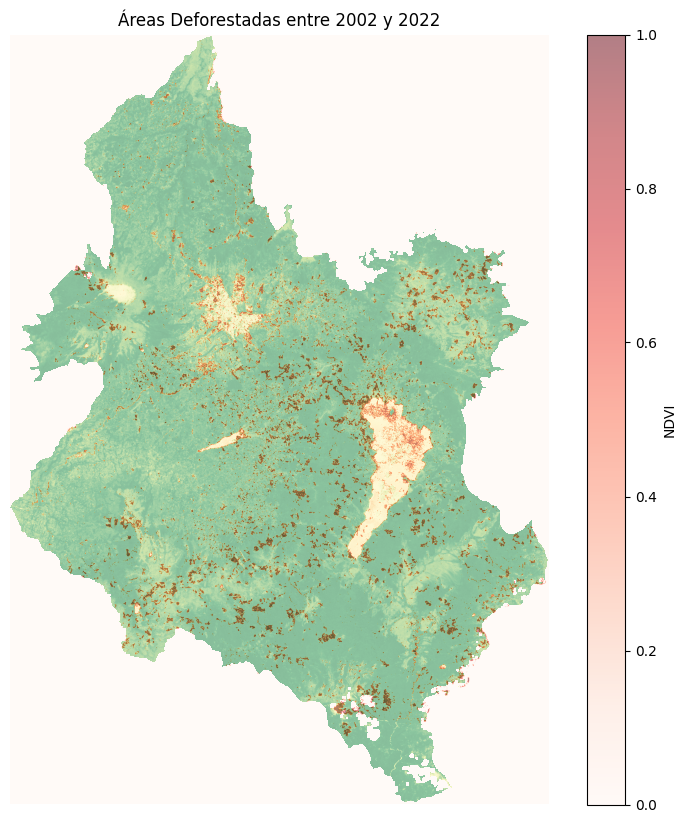

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(ndvi2022_mask, cmap='RdYlGn', vmin=-1, vmax=1)
plt.imshow(deforestation_mask, cmap='Reds', alpha=0.5)  # Superponer máscara en rojo
plt.title('Áreas Deforestadas entre 2002 y 2022')
plt.colorbar(label='NDVI')
plt.axis('off')

plt.savefig('/content/drive/MyDrive/TFM/Repositorio/3-ndvi_analysis/Results/RHVA_fase1/deforestation_threshold.png', dpi=300, bbox_inches='tight')
plt.show()
